<a href="https://colab.research.google.com/github/OussamaLafdil/CNN-CancerDetection/blob/main/ResNet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [37]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D ,Dropout
from tensorflow.keras.models import Model ,load_model
from tensorflow.keras.optimizers import Adam
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.callbacks import ModelCheckpoint ,ReduceLROnPlateau
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns
import os

##Loading the data

In [38]:
# Chemins vers les répertoires des images
augmented_data_path = '/content/drive/MyDrive/Augmented_Dataset'


class_labels = os.listdir(augmented_data_path)
print(f"Class Labels: {class_labels}")

Class Labels: ['Early', 'Pro', 'Pre', 'Benign']


In [39]:
image_paths = []
labels = []

# get the image paths and labels
for label in class_labels:
    folder_path = os.path.join(augmented_data_path, label)
    for image_file in os.listdir(folder_path):
        image_path = os.path.join(folder_path, image_file)
        image_paths.append(image_path)
        labels.append(label)

class_counts = Counter(labels)

In [40]:
# Chemin vers les images
image_arrays = []
for img_path in image_paths:
    with Image.open(img_path) as img:
        img = img.resize((224, 224))  # Redimensionner à 224x224
        image_arrays.append(np.array(img))

# Convertir en un tableau numpy
all_images = np.stack(image_arrays)
np.save('processed_images.npy', all_images)  # Sauvegarde en fichier .npy

In [41]:
# Charger les images traitées
all_images = np.load('processed_images.npy')

##Plotting Class distributions

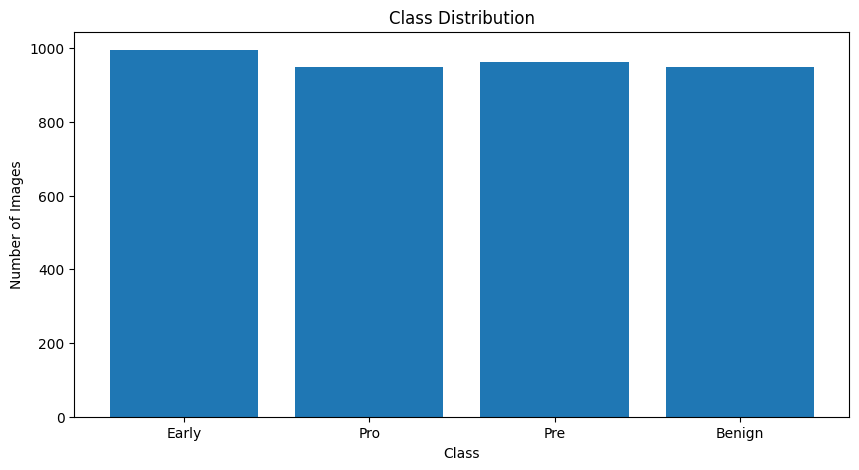

In [42]:
# plot the distribution of classes
plt.figure(figsize=(10, 5))
plt.bar(class_counts.keys(), class_counts.values())
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.show()

##Encoding labels : one-hot encoding

In [43]:
class_names = list(set(labels))
label_to_index = {label: index for index, label in enumerate(class_names)}
labels_encoded = [label_to_index[label] for label in labels]
labels_categorical = to_categorical(labels_encoded, num_classes=len(class_names))

##Split Data into train and validation set

In [44]:
X_train, X_temp, y_train, y_temp = train_test_split(all_images, np.array(labels_categorical), test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

##Pixel Normalization

In [45]:
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

##ResNet50 Model

In [46]:
# Création du modèle basé sur ResNet50 avec des poids préentraînés sur ImageNet
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Geler toutes les couches de ResNet50
for layer in base_model.layers:
    layer.trainable = False

In [47]:
# Ajout de couches personnalisées
x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
output_layer = Dense(4, activation='softmax')(x)  # 4 classes : Bengin, Early, Pre, Pro

In [48]:
model = Model(inputs=base_model.input, outputs=output_layer)

 ## Déclaration du checkpoint pour sauvegarder le meilleur modèle

In [49]:
checkpoint = ModelCheckpoint(
    'best_model.keras',            # Changed the file extension to .keras
    monitor='val_accuracy',        # Metric to monitor (validation accuracy)
    verbose=1,                     # Verbose output
    save_best_only=True,           # Only save the model if it’s the best
    mode='max'                     # Save when val_accuracy is maximized
)


## Entraînement du modèle

In [50]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
# Applique un facteur de réduction de 0.5 si 'val_loss' ne s'améliore pas après 3 epochs.

# Compiler le modèle pour la première phase avec les couches gelées
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Entraînement de la première phase ( 20 premières époques)
history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[checkpoint, reduce_lr]
)

Epoch 1/30
85/85 [==============================] - ETA: 0s - loss: 3.0598 - accuracy: 0.4074
Epoch 1: val_accuracy improved from -inf to 0.52504, saving model to best_model.keras
85/85 [==============================] - 93s 1s/step - loss: 3.0598 - accuracy: 0.4074 - val_loss: 0.9885 - val_accuracy: 0.5250
Epoch 2/30
85/85 [==============================] - ETA: 0s - loss: 1.0221 - accuracy: 0.5500
Epoch 2: val_accuracy improved from 0.52504 to 0.54059, saving model to best_model.keras
85/85 [==============================] - 89s 1s/step - loss: 1.0221 - accuracy: 0.5500 - val_loss: 0.9060 - val_accuracy: 0.5406
Epoch 3/30
85/85 [==============================] - ETA: 0s - loss: 0.9239 - accuracy: 0.6030
Epoch 3: val_accuracy improved from 0.54059 to 0.61831, saving model to best_model.keras
85/85 [==============================] - 90s 1s/step - loss: 0.9239 - accuracy: 0.6030 - val_loss: 0.8895 - val_accuracy: 0.6183
Epoch 4/30
85/85 [==============================] - ETA: 0s - loss:

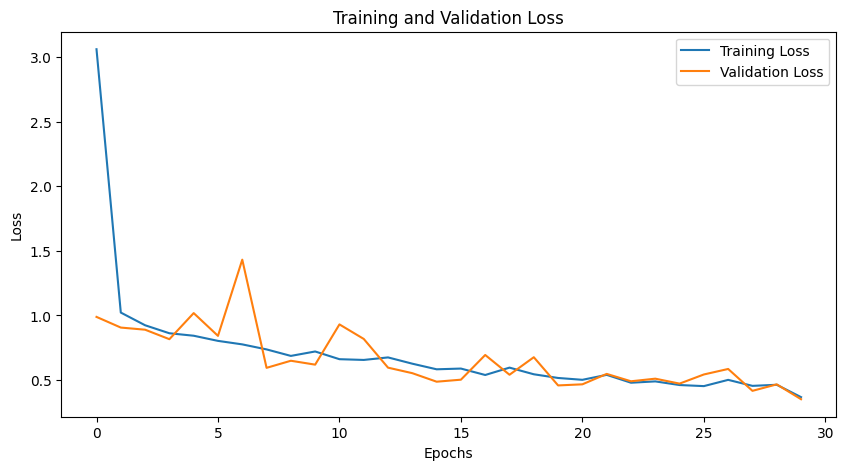

In [51]:
# Extraire les données de perte pour la phase d'entraînement
train_loss = history.history['loss']
val_loss = history.history['val_loss']


# plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [52]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)


report = classification_report(y_true, y_pred_classes, target_names=class_names)
print("Classification Report:\n", report)

19/19 [==============================] - 11s 530ms/step
Classification Report:
               precision    recall  f1-score   support

         Pre       0.83      0.90      0.86       142
         Pro       0.88      0.99      0.93       140
      Benign       0.92      0.85      0.88       139
       Early       0.89      0.79      0.84       158

    accuracy                           0.88       579
   macro avg       0.88      0.88      0.88       579
weighted avg       0.88      0.88      0.88       579



In [54]:
best_model = load_model('best_model.keras')

In [55]:
# evaluate the model on validation set
val_loss, val_accuracy = best_model.evaluate(X_val, y_val)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

19/19 [==============================] - 12s 517ms/step - loss: 0.3516 - accuracy: 0.8601
Validation Accuracy: 86.01%


In [56]:
y_pred = best_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)


report = classification_report(y_true, y_pred_classes, target_names=class_names)
print("Classification Report:\n", report)

19/19 [==============================] - 10s 493ms/step
Classification Report:
               precision    recall  f1-score   support

         Pre       0.83      0.90      0.86       142
         Pro       0.88      0.99      0.93       140
      Benign       0.92      0.85      0.88       139
       Early       0.89      0.79      0.84       158

    accuracy                           0.88       579
   macro avg       0.88      0.88      0.88       579
weighted avg       0.88      0.88      0.88       579



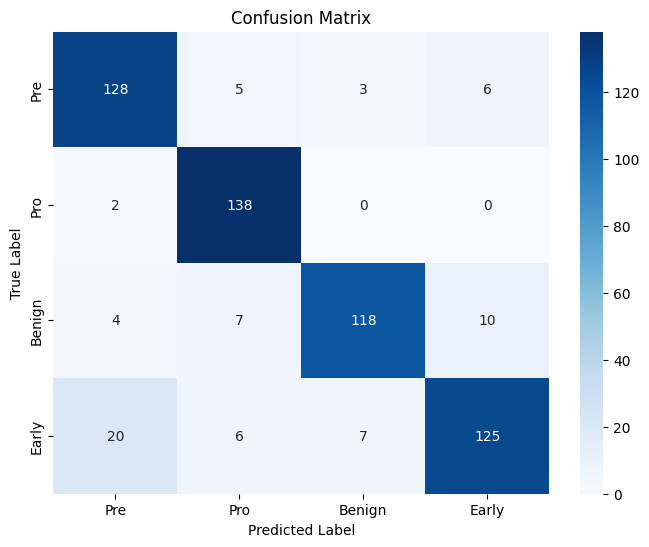

In [57]:
conf_matrix = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()